# RNOG_CNN_Detection Alpha

Mock model to try to identify average voltage SNR from a single station with 4 v-pols.

From station.json comment: 
> *a surface station with 4 downward facing LPDAs and 4 dipoles with 1GHz sampling, i.e., the bandwidth is 0-500MHz*

In [1]:
# imports
from torch.utils.data import DataLoader
from typing import Tuple, Dict, List
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from pathlib import Path
from torch import nn
import numpy as np
import random
import pickle
import torch
import sys

sys.path.append('/data/condor_shared/users/ssued/RNOGCnn')
import utils

torch.__version__

/data/i3home/ssued/venv_ubu22.04/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


'2.5.1+cu124'

In [3]:
# Import events
eventbatch = utils.obtain_evb('eventbatch.pkl')
# Split the eventbatch_k into 75% training and 25% testing
# Calculate the split index
split_index = int(len(eventbatch) * 0.75)

# Split the eventbatch_k into 75% training and 25% testing
train_eventbatch = dict(list(eventbatch.items())[:split_index])
test_eventbatch = dict(list(eventbatch.items())[split_index:])

print(f'Size of train_eventbatch = {len(train_eventbatch.keys())}')
print(f'Size of test_eventbatch = {len(test_eventbatch.keys())}')

Size of train_eventbatch = 3741
Size of test_eventbatch = 1248


In [ ]:
# Initialize data and print out lengths:
train_data = utils.EventtoData(train_eventbatch)
test_data = utils.EventtoData(test_eventbatch)

print(f'Training data: {len(train_data)} events')
print(f'Testing data: {len(test_data)} events')

BATCH_SIZE = 5 # Small batch size just to test batch size feature

train_data_loader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle=False)
test_data_loader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False)

Training data: 3741 events
Testing data: 1248 events


In [6]:
from torch import nn
# Let there be light!

class RNOG_CNN_alpha_1(nn.Module):

    def __init__(self,input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        KERNEL_HEIGHT = 4
        KERNEL_WIDTH = 25
        KERNEL_SIZE = (KERNEL_HEIGHT,KERNEL_WIDTH)

        self.conv_block_1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=output_shape,
                      kernel_size=KERNEL_SIZE,
                      stride=1),
        )

    def forward(self,x):
        x = self.conv_block_1(x)
        return x

In [5]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
random_events = dict(random.choices(list(eventbatch.items()), k=20))

random_data = EventtoData(random_events)

random_dataloader = DataLoader(random_data,1,False)

model_1.eval()
loss_fn = nn.MSELoss()

with torch.inference_mode():
    for i, (data, snr) in enumerate(random_dataloader):
        data, snr = data.to(device), snr.to(device)
        pred = model_1(data)
        loss = loss_fn(pred, snr)
        print(f"Data Point {i + 1}: Loss = {loss.item():.6f}")

### Training and Testing Steps

In [220]:
# Train_step function:

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss
    #train_loss = 0
    train_loss_arr = []
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        #Y = y.view_as(y_pred)

        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        #train_loss += loss.item()
        train_loss_arr.append(loss)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Adjust metrics to get average loss per batch
    #train_loss = train_loss / len(dataloader)
    train_loss = min(train_loss_arr)

    return train_loss

In [221]:
# Test step function:

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test values
    #test_loss = 0
    test_loss_arr = []

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred = model(X)
            #Y = y.view_as(test_pred)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred, y)
            #test_loss += loss.item()
            test_loss_arr.append(loss)
            
    # Adjust metrics to get average loss per batch 
    #test_loss = test_loss / len(dataloader)
    test_loss = min(test_loss_arr)
    return test_loss

In [ ]:
# Train function (Combines both steps)

from torch.optim.lr_scheduler import ExponentialLR
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler.LRScheduler,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "test_loss": [],
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer)
        test_loss = test_step(model=model,
                              dataloader=test_dataloader,
                              loss_fn=loss_fn)
        if scheduler:
            scheduler.step()

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch} | "
            f"train_loss: {train_loss:.10f} | "
            f"test_loss: {test_loss:.10f} | "
        )
        if scheduler:
            print(f"learning_rate: {scheduler.get_last_lr():.10f}")

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)

    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
# Set number of epochs
NUM_EPOCHS = 50

# Create model_0
model_0 = RNOG_CNN_ALPHA_0(input_shape=1, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=1)

# Setup loss function and optimizer
loss_fn = nn.MSELoss()
#loss_fn = nn.HuberLoss(delta=0.01)
#loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.1)
scheduler = False#ExponentialLR(optimizer, gamma=0.9)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_data_loader,
                        test_dataloader=test_data_loader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)
    
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 0.0065174229 | test_loss: 0.0019156167 | 
Epoch: 1 | train_loss: 0.0010520553 | test_loss: 0.0113485502 | 
Epoch: 2 | train_loss: 0.0010548112 | test_loss: 0.0086024106 | 
Epoch: 3 | train_loss: 0.0024063047 | test_loss: 0.0087848660 | 
Epoch: 4 | train_loss: 0.0070553995 | test_loss: 0.0022025406 | 
Epoch: 5 | train_loss: 0.0063690096 | test_loss: 0.0019060193 | 
Epoch: 6 | train_loss: 0.0061707729 | test_loss: 0.0019036748 | 
Epoch: 7 | train_loss: 0.0061662360 | test_loss: 0.0018981522 | 
Epoch: 8 | train_loss: 0.0060505522 | test_loss: 0.0019143347 | 
Epoch: 9 | train_loss: 0.0041153049 | test_loss: 0.0019638273 | 
Epoch: 10 | train_loss: 0.0028060875 | test_loss: 0.0020438910 | 
Epoch: 11 | train_loss: 0.0020047938 | test_loss: 0.0021457609 | 
Epoch: 12 | train_loss: 0.0015824815 | test_loss: 0.0022608025 | 
Epoch: 13 | train_loss: 0.0014273712 | test_loss: 0.0023825639 | 
Epoch: 14 | train_loss: 0.0014516537 | test_loss: 0.0025065290 | 
Epoch: 15 | train_lo

### Evaluate the model!

In [224]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss = 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            y = y.view_as(y_pred)  # Reshape y to match y_pred
            loss += loss_fn(y_pred, y)
        
        # Scale loss and acc
        loss /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item()}

In [225]:
model_0_eval=eval_model(model=model_0,
                           data_loader=train_data_loader,
                           loss_fn=loss_fn,
                           device=device)

model_0_eval

{'model_name': 'RNOG_CNN_alpha', 'model_loss': 0.2342691570520401}

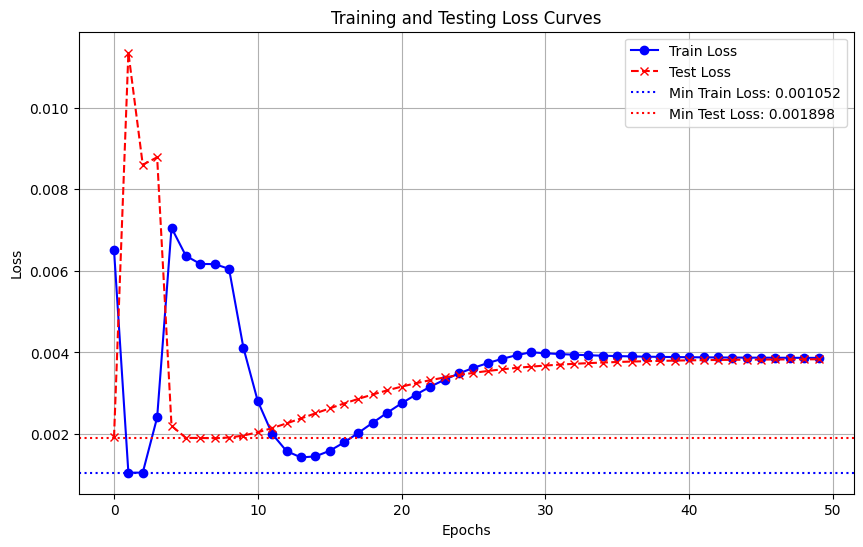

In [226]:
# Plot loss curves with improved aesthetics:
epochs = np.arange(NUM_EPOCHS)
train_loss = model_0_results['train_loss']
test_loss = model_0_results['test_loss']

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Train Loss', color='blue', linestyle='-', marker='o')
plt.plot(epochs, test_loss, label='Test Loss', color='red', linestyle='--', marker='x')

# Plot minimum loss horizontal lines
min_train_loss = min(train_loss)
min_test_loss = min(test_loss)
plt.axhline(y=min_train_loss, color='blue', linestyle=':', label=f'Min Train Loss: {min_train_loss:.6f}')
plt.axhline(y=min_test_loss, color='red', linestyle=':', label=f'Min Test Loss: {min_test_loss:.6f}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

### Lets see how well it can predict a new voltage!

In [227]:
# Select 20 random events from eventbatch
random_events = dict(random.choices(list(eventbatch.items()), k=20))

random_data = EventtoData(random_events)

random_dataloader = DataLoader(random_data,1,False)

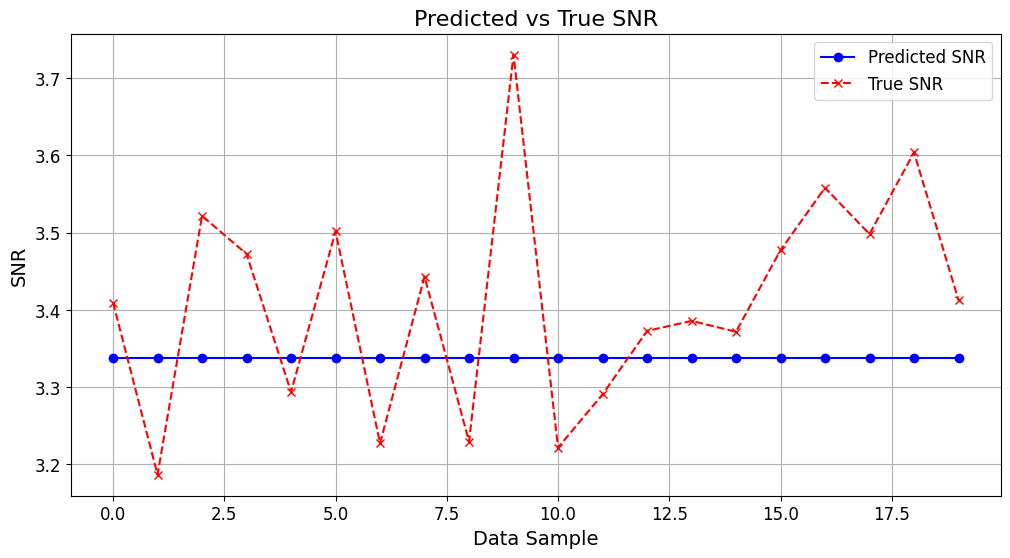

In [228]:
def make_predictions(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, device: torch.device = device, plot: bool = False):
    predictions = []
    model.eval()
    with torch.inference_mode():
        for data, snr in dataloader:
            data = data.to(device)
            pred = model(data)
            predictions.append((pred.cpu().item(), snr.cpu().item()))

    if plot:
        pred_values, true_values = zip(*predictions)
        samples = np.arange(len(pred_values))

        plt.figure(figsize=(12, 6))
        plt.plot(samples, pred_values, label='Predicted SNR', marker='o', linestyle='-', color='blue')
        plt.plot(samples, true_values, label='True SNR', marker='x', linestyle='--', color='red')
        plt.xlabel('Data Sample', fontsize=14)
        plt.ylabel('SNR', fontsize=14)
        plt.title('Predicted vs True SNR', fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

    return predictions

preds = make_predictions(model_0, random_dataloader, device=device, plot=True)


Save model:

In [ ]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save path
MODEL_NAME='RNOG_alpha_model_0.pth'
MODEL_SAVE_PATH=MODEL_PATH/MODEL_NAME

print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_0.state_dict(),f=MODEL_SAVE_PATH)